# Indoor Positioning over h-Estimated  LoS

Notebook for the CTW Competition 2019:

By Maximilian Arnold, Marc Gauger,  Jakob Hoydis, and Stephan ten Brink.
Contact: arnold / gauger / tenbrink@inue.uni-stuttgart.de

This code is provided for the CTW Competition: Indoor user localisation.
It is licensed under the GPLv2 license. If you in any way use this code for research that results in publications, please cite it appropriately. 

Paper: Novel Massive MIMO Channel Sounding Data Applied to Deep Learning-based Indoor Positioning


# Settings LoS

In [1]:
# Data Sets
Nb_of_Datasets = 1
Data_Foldername = './1_Measured_Data/'

Meas_Comb_h =    "%s/h_Estimated_CTW.mat" % (Data_Foldername)
Meas_Comb_r =    "%s/r_Position_CTW.mat" % (Data_Foldername)
Meas_Comb_SNR =   "%sSNR_CTW_Train.mat" % (Data_Foldername)

# Filename Array
Filenames_h =  [Meas_Comb_h]
Filenames_r =  [Meas_Comb_r]

# Traniningsize 
TrainingsSize = 0.9# 90 %

In [2]:
## Input Settings ########################################
# NN Settings
nb_epoch =50                           # number of learning epochs
batch_sizes = [8,64,128,256,1024]             # size of batches for calculation the gradient

# Number of Antennas 
Nb_Antennas = [2,4,8,16]

# OutputName
Filename_Pre = './2_Results/';

# Standard Includes

In [3]:
import os
import random
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tensorflow as tf
import keras.backend.tensorflow_backend as KTF
def get_session(gpu_fraction=1):
    
    num_threads = os.environ.get('OMP_NUM_THREADS')
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=gpu_fraction)

    if num_threads:
        return tf.Session(config=tf.ConfigProto(
            gpu_options=gpu_options, intra_op_parallelism_threads=num_threads))
    else:
        return tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

KTF.set_session(get_session())
import numpy as np
import hdf5storage
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Lambda, Reshape, Conv1D, Conv2D, AveragePooling2D,Flatten, Dropout, SimpleRNN, LSTM, concatenate
from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
from IPython.core.display import Image, display
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import axes3d
from numpy import ma
import scipy.io as sio
from IPython.display import Image
from matplotlib import cm as CM
from nbconvert import HTMLExporter
import keras
keras.__version__
!nvidia-smi

# Distance Functions
def dist(y_true, y_pred):    
    return tf.reduce_mean((tf.sqrt(tf.square(tf.abs(y_pred[:,0]-y_true[:,0]))+tf.square(tf.abs(y_pred[:,1]-y_true[:,1]))+tf.square(tf.abs(y_pred[:,2]-y_true[:,2])))))

def true_dist(y_true, y_pred):    
    return (np.sqrt(np.square(np.abs(y_pred[:,0]-y_true[:,0]))+np.square(np.abs(y_pred[:,1]-y_true[:,1]))+np.square(np.abs(y_pred[:,2]-y_true[:,2]))))


Using TensorFlow backend.


Tue Jan 29 08:31:40 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.130                Driver Version: 384.130                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  On   | 00000000:02:00.0 Off |                  N/A |
| 42%   63C    P2   239W / 300W |  11155MiB / 11172MiB |     95%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:03:00.0 Off |                  N/A |
| 52%   67C    P2    82W / 300W |  10776MiB / 11170MiB |     82%      Default |
+-------------------------------+----------------------+----------------------+
        

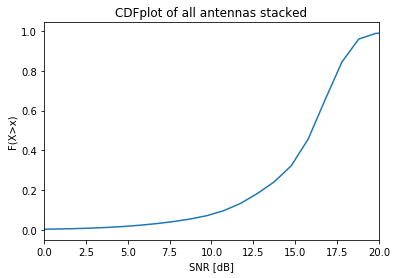

In [23]:
# Example for Measurement Quality
SNR_Mat = hdf5storage.loadmat(Meas_Comb_SNR)
SNR_Meas = np.transpose(SNR_Mat['SNR_Est'])


num_bins = 50
# Use the histogram function to bin the data
counts, bin_edges = np.histogram(SNR_Meas, bins=num_bins, normed=True)

# Now find the cdf
cdf = np.cumsum(counts)

# And finally plot the cdf
plt.plot(bin_edges[1:], cdf)
plt.xlim(0, 20)
plt.xlabel('SNR [dB]')
plt.ylabel('F(X>x)')
plt.title('Cdfplot of all antennas stacked')
plt.show()

## Sweep over Datasets

In [ ]:
# Allocate Space for Results
Mean_Error_Train = np.empty([np.int(Nb_of_Datasets),len(Nb_Antennas)])
Mean_Error_Test = np.empty([np.int(Nb_of_Datasets),len(Nb_Antennas)])

# Sweep over Datasets
for Current_Dataset_Index in range(0,Nb_of_Datasets,1):
    ## Load Current Dataset
    VariableName_h = Filenames_h[Current_Dataset_Index]
    VariableName_r = Filenames_r[Current_Dataset_Index]
    
    # h_Estimated
    h_Estimated_Mat = hdf5storage.loadmat(VariableName_h)
    h_Estimated = np.transpose(h_Estimated_Mat['h_Estimated'])
    h_Estimated = np.swapaxes(h_Estimated ,0,2)
    h_Estimated = np.stack((np.real(h_Estimated),np.imag(h_Estimated)),axis=-1)

    # Labels
    position = sio.loadmat(VariableName_r)
    target_pos = np.transpose(position['r_Position'])
    target_pos = np.swapaxes(target_pos,0,1)

    # Schuffle
    shuffling_index =random.sample(range(target_pos[:,0].size),target_pos[:,0].size);
    h_Estimated = h_Estimated[shuffling_index,:,:,:]
    target_pos =  target_pos[shuffling_index,:]
    target_pos = target_pos
    target_pos[:,0] = target_pos[:,0]
    target_pos[:,1] = target_pos[:,1]
    
    # Split Data
    h_Estimated_train_saved = h_Estimated[0:int(TrainingsSize*target_pos[:,0].size),:,:,:]
    Positions_train =   target_pos[0:int(TrainingsSize*target_pos[:,0].size),:]
    h_Estimated_test_saved =  h_Estimated[int(TrainingsSize*target_pos[:,0].size):,:,:,:]
    Positions_test =    target_pos[int(TrainingsSize*target_pos[:,0].size):,:]
    Length_Test = len(Positions_test[:,0])


    for Antenna_index in range (0,len(Nb_Antennas)):
        # Current Nb Antennas
        Current_Nb_Antennas = Nb_Antennas[Antenna_index]
        h_Estimated_train = h_Estimated_train_saved[:,0::int(16/Current_Nb_Antennas),:,:]
        h_Estimated_test =  h_Estimated_test_saved[:,0::int(16/Current_Nb_Antennas),:,:]
              
        #Create Net 
        nn_input  = Input((Current_Nb_Antennas,924,2))
        nn_output = Flatten()(nn_input)
        nn_output = Dense(128,activation='relu')(nn_output)
        nn_output = Dense(256,activation='relu')(nn_output)
        nn_output = Dense(128,activation='relu')(nn_output)
        nn_output = Dense(3,activation='linear')(nn_output)
        nn = Model(inputs=nn_input,outputs=nn_output)
        nn.compile(optimizer='Adam', loss='mse',metrics=[dist])
        nn.summary()
 
    
        # Train Neural Network
        for b in batch_sizes:
            train_hist = nn.fit(x=h_Estimated_train,y=Positions_train,batch_size=b,epochs=nb_epoch,validation_data=(h_Estimated_test, Positions_test))
        
        # Evaluate Performance
        r_Positions_pred_train = nn.predict(h_Estimated_train)
        r_Positions_pred_test = nn.predict(h_Estimated_test)
        errors_train = true_dist(Positions_train,r_Positions_pred_train)
        errors_test  = true_dist(Positions_test,r_Positions_pred_test)
       
        Mean_Error_Train[Current_Dataset_Index,Antenna_index] =  np.mean(np.abs(errors_train))
        Mean_Error_Test[Current_Dataset_Index,Antenna_index] = np.mean(np.abs(errors_test))
        print("Mean error on Train area:",  Mean_Error_Train[Current_Dataset_Index,Antenna_index])
        print("Mean error on Test  area:",Mean_Error_Test[Current_Dataset_Index,Antenna_index])


In [ ]:
# Median Error
plt.plot(Nb_Antennas,Mean_Error_Test[0,:])
plt.xlabel('Number of antennas')
plt.ylabel('Distance error')

In [ ]:
# Histogramm of errors on test Area
errors = true_dist(r_Positions_pred_test , Positions_test)
plt.hist(errors,bins=64,range=(0,4))
plt.ylabel('Number of occurence')
plt.xlabel('Distance error')


In [ ]:
# Error Vector over Area in XY
error_vectors = np.real(r_Positions_pred_test - Positions_test)
plt.figure(figsize=(15,15))
plt.quiver(np.real(Positions_test[:,0]),np.real(Positions_test[:,1]),error_vectors[:,0],error_vectors[:,1],errors)
plt.xlabel("x in m")
plt.ylabel("y in m")
plt.show()